In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from matplotlib.image import imread
from sklearn import cluster, metrics
from sklearn import preprocessing
from sklearn import manifold, decomposition
from sklearn.model_selection import train_test_split
import cv2
import time

import tensorflow as tf
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten


2022-07-18 15:59:58.416932: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-07-18 15:59:58.416986: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
data = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')
print(f'Le fichier data contient {data.shape[0]} lignes et {data.shape[1]} colonnes')

Le fichier data contient 1050 lignes et 15 colonnes


In [3]:
# Ajout des catégories
data['First_category'] = data.product_category_tree.str.split(' >> ', expand=True)[0]
data['First_category'] = data['First_category'].str[2:]  # Suppression des 2 premiers caractères ["
categories = data['First_category'].unique().tolist()

In [4]:
data.groupby('First_category').count()['uniq_id']

First_category
Baby Care                     150
Beauty and Personal Care      150
Computers                     150
Home Decor & Festive Needs    150
Home Furnishing               150
Kitchen & Dining              150
Watches                       150
Name: uniq_id, dtype: int64

In [5]:
categories

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

### Création des labels en fonction des catégories  
Nécessaire pour le calcul ARI avec les numéros de cluster

In [6]:
le = preprocessing.LabelEncoder()
data["label"] = le.fit_transform(data["First_category"])
data.groupby('label').count()['uniq_id']

label
0    150
1    150
2    150
3    150
4    150
5    150
6    150
Name: uniq_id, dtype: int64

In [7]:
# Récupération du nom des photos
path = '/home/agent/OpenclassRoom/P6/Images/'
list_photos = [file for file in listdir(path)]
print(len(list_photos))

1050


In [8]:
# Vérification que les noms des photos correspondent aux noms dans le dataframe (que pour chaque description, une photo différente existe)
len(data[data['image'].isin(list_photos)]) == len(data)

True

## Affichage d'exemples d'images par catégorie

-------
Home Furnishing


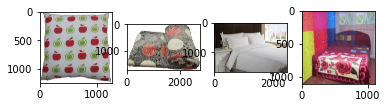

-------
Baby Care


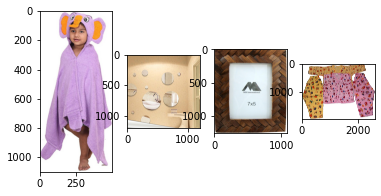

-------
Watches


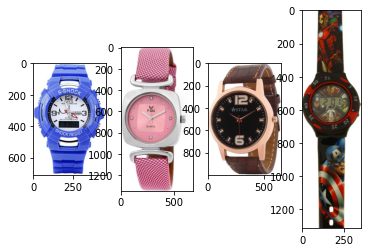

-------
Home Decor & Festive Needs


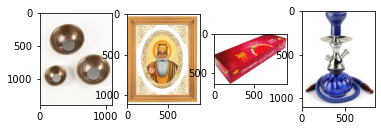

-------
Kitchen & Dining


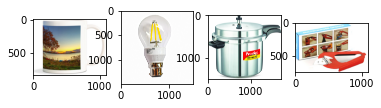

-------
Beauty and Personal Care


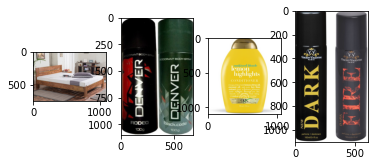

-------
Computers


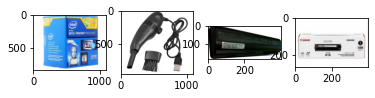

In [9]:
def nom_image(categorie) :
    nom_image = [data['image'][i] for i in range(len(data)) if data['First_category'][i]==categorie]
    return nom_image


for c in categories :
    print("-------")
    print(c)
    for i in range(4):
        plt.subplot(140 + 1 + i)
        chemin_complet = path + nom_image(c)[np.random.randint(150)]  # Possibilité d'afficher toujours les mêmes en remplacement le random par un entier
        image = imread(chemin_complet)
        plt.imshow(image)
    # plt.figure(figsize=(3,3))
    plt.show()

# Méthode SIFT

## Test descripteurs sur une image

[ WARN:0@6.299] global /io/opencv_contrib/modules/xfeatures2d/misc/python/shadow_sift.hpp (13) SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


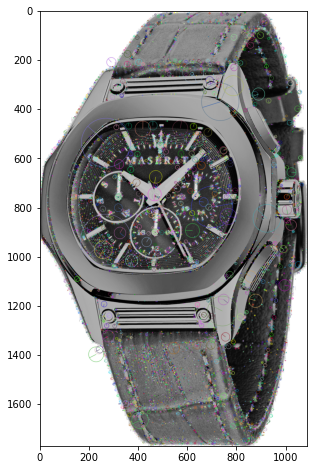

Descripteurs :  (7962, 128)

[[104.  14.   1. ...   1.   2.   0.]
 [ 53.   0.   0. ...   0.   2.   5.]
 [ 49.   1.   0. ...   2.   3.   3.]
 ...
 [141.   0.   0. ...   0.   1.   1.]
 [166.  30.   0. ...   0.   6.  20.]
 [147.  16.   0. ...   0.   0.   0.]]


In [10]:

sift = cv2.xfeatures2d.SIFT_create()
image = cv2.imread(path+data['image'][5],0) # convertit en nuange de gris
image = cv2.equalizeHist(image)   # Histogram Equalization = améliore le contraste - fait en sorte que les points "noyés" soient plus visibles
kp, descripteurs = sift.detectAndCompute(image, None) # Détecte les Keypoints et créer les descripteurs
img=cv2.drawKeypoints(image,kp,image,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # Permet de rendre les keypoint plus visible sur l'image
# img=cv2.drawKeypoints(image,kp,image)
plt.figure(figsize=(5,8))
plt.imshow(img)
plt.show()
print("Descripteurs : ", descripteurs.shape)
print()
print(descripteurs)

Pour cette image, 7962 decripteurs ont été trouvés d'une longueur de 128

## Création des descripteurs pour l'ensemble des images

In [11]:
# identification of key points and associated descriptors

sift_keypoints = []
temps1=time.time()
sift = cv2.xfeatures2d.SIFT_create()  # Nombre de descripteurs max par photo (si rien renseigné, l'algorithme les prend tous) 

for numero_image in range(len(data)):
    if numero_image%100 == 0 : print(numero_image)
    image = cv2.imread(path+data['image'][numero_image],0) # convertit en nuange de gris
    image = cv2.equalizeHist(image)   # Histogram Equalization = améliore le contraste - fait en sorte que les points "noyés" soient plus visibles
    kp, descripteurs = sift.detectAndCompute(image, None) # Détecte les Keypoints et créer les descripteurs
    sift_keypoints.append(descripteurs)

sift_keypoints_par_image = np.asarray(sift_keypoints)  # Utile pour la construction dse histogrammes 
sift_keypoints_total = np.concatenate(sift_keypoints_par_image, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_total.shape)

duration1=time.time()-temps1
print("Temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)



Nombre de descripteurs :  (9051347, 128)
Temps de traitement SIFT descriptor :           399.29 secondes


In [12]:
# Calcul d'un nombre de clusters permettant de réduire les 9 millions de descripteurs
temps1=time.time()
k = int(round(np.sqrt(len(sift_keypoints_total)),0))  # On prend la racine carrée du nombre total de descripteurs
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=k*3, random_state=0)
kmeans.fit(sift_keypoints_total)

duration1=time.time()-temps1
print("Temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  3009
Création de 3009 clusters de descripteurs ...
Temps de traitement kmeans :           197.98 secondes


## Création des features des images
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [13]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_par_image) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calcule les histogrammes pour chaque image
    hist_vectors.append(hist) # Regroupe l'ensemble des histogrammes dans une liste

im_features = np.asarray(hist_vectors) # On a donc un array d'une longueur de 1050 avec 719 valeurs par lignes. Cela correspond à une ligne / image et les clusters comme features. Les valeurs sont les nombre de descripteurs par cluster est simplelent le nombre de 

duration1=time.time()-temps1
print("Temps de création histogrammes : ", "%15.2f" % duration1, "secondes")
print("La taille de la matrice image/cluster est de : ", im_features.shape)

0
100
200
300
400
500
600
700
800
900
1000
Temps de création histogrammes :            50.07 secondes
La taille de la matrice image/cluster est de :  (1050, 3009)


## Réductions de dimension

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [14]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 3009)
Dimensions dataset après réduction PCA :  (1050, 752)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [15]:
tsne = manifold.TSNE(n_components=2, perplexity=31, 
                     n_iter=2000, init='random', random_state=42)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["First_category"]
print(df_tsne.shape)

/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


## Analyse visuelle : affichage T-SNE selon catégories d'images

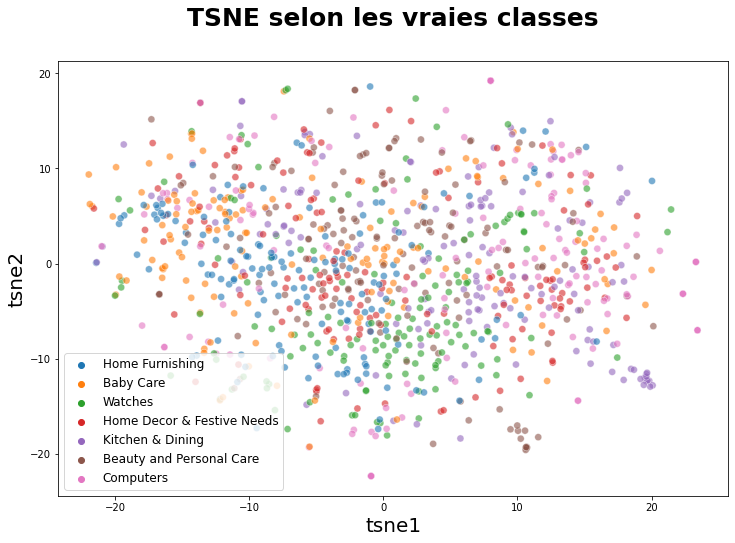

In [16]:
plt.figure(figsize=(12,8))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 25, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 20)
plt.ylabel('tsne2', fontsize = 20)
plt.legend(prop={'size': 12}) 

plt.show()

## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [17]:
cls = cluster.KMeans(n_clusters=7, random_state=42)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


###  Comparaison des images selon clusters et calcul ARI de similarité catégories images / clusters

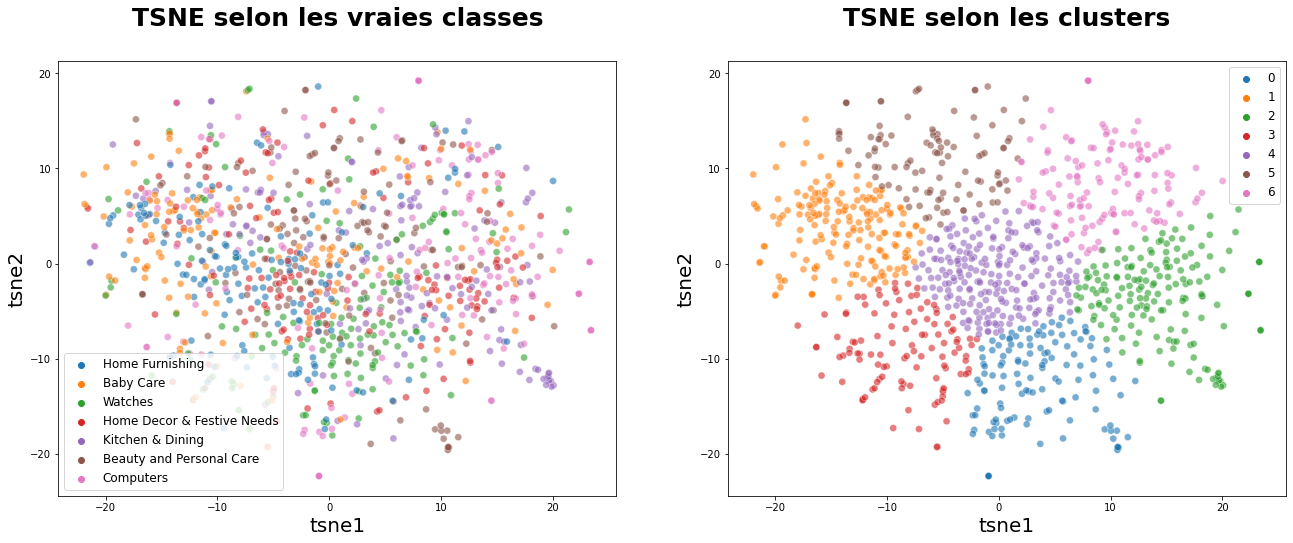

Score ARI :  0.05135733666599399


In [18]:
plt.rcParams["figure.figsize"] = (22,8)
fig, axes = plt.subplots(1,2)

sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,ax=axes[0])
axes[0].set_title('TSNE selon les vraies classes', fontsize = 25, pad = 35, fontweight = 'bold')
# plt.xlabel('tsne1' fontsize = 20)
# plt.ylabel('tsne2', fontsize = 20)
# plt.legend(prop={'size': 12}) 

sns.scatterplot(
    x="tsne1", y="tsne2", hue="cluster", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,ax=axes[1])
axes[1].set_title('TSNE selon les clusters', fontsize = 25, pad = 35, fontweight = 'bold')

for i in range(2):
    axes[i].set_xlabel('tsne1', fontsize = 20)
    axes[i].set_ylabel('tsne2', fontsize = 20)
    axes[i].legend(prop={'size': 12}) 

plt.show()


# Calcul ARI
labels = data["label"]
print("Score ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

# CNN Transfert learning
## Test 1 - Suppression de la dernière couche (uniquement celle de classification)

In [19]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.9.1
Num GPUs Available:  0
True


2022-07-18 16:11:01.386879: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 16:11:01.389517: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-07-18 16:11:01.389871: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-07-18 16:11:01.390179: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasL

In [20]:
def creation_feature(image,model):
    img = load_img(image, target_size=(224, 224))
    img = img_to_array(img)  # Convertir l'image en un array
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Reshape pour les besoins du modèle VGG
    img = preprocess_input(img)  # Preprocessing pour les besoins du modèle (soustraction de la moyenne RGB du modèle d'entrainement)
    features = model.predict(img,verbose=0)
    return features

In [21]:
# Création du modèle VGG
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)  # Suppression de la dernière couche
model.summary()

2022-07-18 16:11:03.247465: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-18 16:11:03.504745: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.
2022-07-18 16:11:03.604755: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.
2022-07-18 16:11:03.655365: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

2022-07-18 16:11:04.889200: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.


In [22]:
# Création des features
CNN_features = []

temps1=time.time()

for i in range(len(data)):
    features = creation_feature(path+data['image'][i],model)
    CNN_features.append(features)

duree = time.time() - temps1

CNN_features_par_image = np.asarray(CNN_features)
CNN_features_total = np.concatenate(CNN_features_par_image, axis=0)


print("Durée de création des features :" ,"%15.2f" % duree, "secondes")
print("Taille matrice :" , CNN_features_total.shape)

/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Durée de création des features :          161.60 secondes
Taille matrice : (1050, 4096)


## Réductions de dimension

### Réduction de dimension PCA

In [23]:
print("Dimensions dataset avant réduction PCA : ", CNN_features_total.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(CNN_features_total)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 4096)
Dimensions dataset après réduction PCA :  (1050, 803)


### Réduction de dimension T-SNE

In [24]:
def application_TSNE(array_pca, perplexity=30):
    tsne = manifold.TSNE(n_components=2, perplexity=perplexity, 
                     n_iter=2000, init='random', random_state=42)
    X_tsne = tsne.fit_transform(array_pca)

    df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
    df_tsne["class"] = data["First_category"]
    return X_tsne, df_tsne

In [25]:
# Recherche de la perplexity optimum
# Le juge de paix est le score ARI donc nécessité de réaliser un clustering avec 7 catégories

labels = data["label"]
ARI = []

perplexity_range = [1, 5, 10, 30, 50, 100, 200, 300, 400, 500, 600, 1000]

for i in perplexity_range:
    X_tsne, df_tsne = application_TSNE(feat_pca, perplexity=i)
    cls = cluster.KMeans(n_clusters=7, random_state=42)
    cls.fit(X_tsne)
    ARI.append([metrics.adjusted_rand_score(labels, cls.labels_)])
    print("Perplexity :" , i, ", ARI :", metrics.adjusted_rand_score(labels, cls.labels_))

/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 1 , ARI : 0.031413064226932984


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 5 , ARI : 0.4387160297565436


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 10 , ARI : 0.44851306977902283


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 30 , ARI : 0.47396761482905003


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 50 , ARI : 0.523372420858721


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 100 , ARI : 0.515277017953912


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 200 , ARI : 0.4728233368187439


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 300 , ARI : 0.4204306417408734


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 400 , ARI : 0.39970208336207347


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 500 , ARI : 0.4089398014367566


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 600 , ARI : 0.3772500198306122


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 1000 , ARI : 0.3254369354284818


In [26]:
# Application TSNE avec la perplexity optimisée
X_tsne, df_tsne = application_TSNE(feat_pca, perplexity=perplexity_range[ARI.index(max(ARI))])

/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


###  Création de clusters à partir du T-SNE

In [27]:
# Application du KMeans
cls = cluster.KMeans(n_clusters=7, random_state=42)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

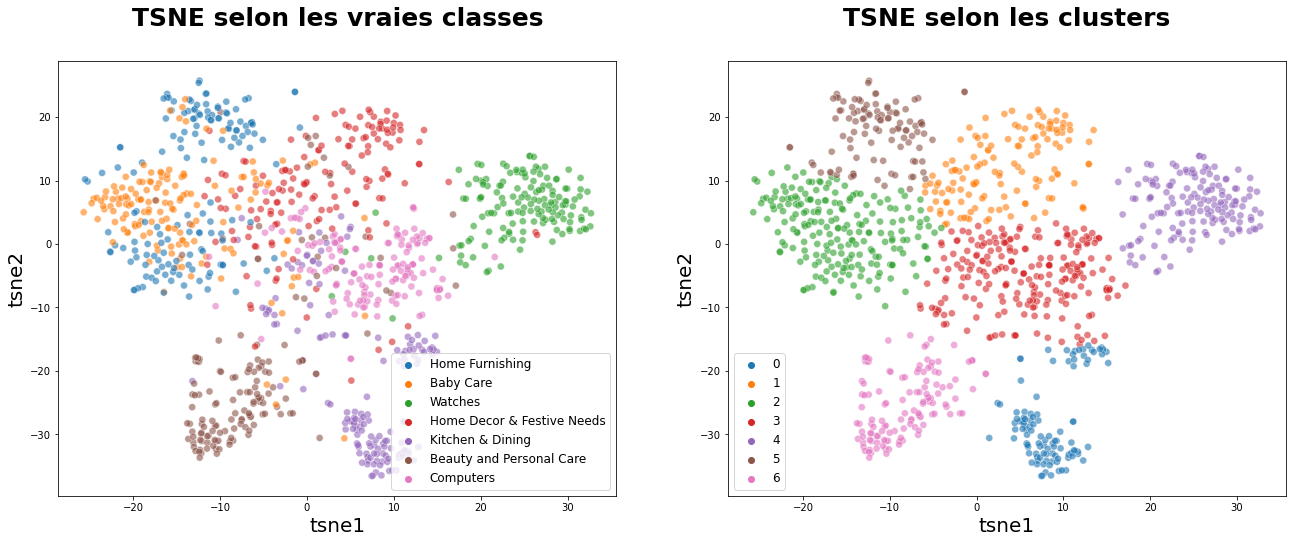

Score ARI :  0.523372420858721


In [28]:
plt.rcParams["figure.figsize"] = (22,8)
fig, axes = plt.subplots(1,2)

sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,ax=axes[0])
axes[0].set_title('TSNE selon les vraies classes', fontsize = 25, pad = 35, fontweight = 'bold')
# plt.xlabel('tsne1' fontsize = 20)
# plt.ylabel('tsne2', fontsize = 20)
# plt.legend(prop={'size': 12}) 

sns.scatterplot(
    x="tsne1", y="tsne2", hue="cluster", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,ax=axes[1])
axes[1].set_title('TSNE selon les clusters', fontsize = 25, pad = 35, fontweight = 'bold')

for i in range(2):
    axes[i].set_xlabel('tsne1', fontsize = 20)
    axes[i].set_ylabel('tsne2', fontsize = 20)
    axes[i].legend(prop={'size': 12}) 

plt.show()


# Calcul ARI
labels = data["label"]
print("Score ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

## Test 2 - Suppression des 3 dernières couches

In [29]:
# Création du modèle VGG
model_2 = VGG16()
model_2 = Model(inputs=model_2.inputs, outputs=model_2.layers[-4].output)
model_2.summary()

2022-07-18 16:15:02.613024: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [30]:
# Création des features
CNN_features = []

temps1=time.time()

for i in range(len(data)):
    features = creation_feature(path+data['image'][i],model_2)
    CNN_features.append(features)

duree = time.time() - temps1

CNN_features_par_image_2 = np.asarray(CNN_features)  # Utile pour la construction dse histogrammes 
CNN_features_total_2 = np.concatenate(CNN_features_par_image_2, axis=0)


print("Durée de création des features :" ,"%15.2f" % duree, "secondes")
print("Taille matrice :" , CNN_features_total_2.shape)

/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Durée de création des features :          134.05 secondes
Taille matrice : (1050, 25088)


## Réductions de dimension

### Réduction de dimension PCA

In [31]:
print("Dimensions dataset avant réduction PCA : ", CNN_features_total_2.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca_2= pca.fit_transform(CNN_features_total_2)
print("Dimensions dataset après réduction PCA : ", feat_pca_2.shape)

Dimensions dataset avant réduction PCA :  (1050, 25088)
Dimensions dataset après réduction PCA :  (1050, 940)


### Réduction de dimension T-SNE

In [32]:
# Recherche de la perplexity optimum
# Le juge de paix est le score ARI donc nécessité de réaliser un clustering avec 7 catégories

labels = data["label"]
ARI = []

perplexity_range = [1, 5, 10, 50, 100, 200, 300, 400, 500, 600, 1000]

for i in perplexity_range:
    X_tsne, df_tsne = application_TSNE(feat_pca_2, perplexity=i)
    cls = cluster.KMeans(n_clusters=7, random_state=42)
    cls.fit(X_tsne)
    ARI.append([metrics.adjusted_rand_score(labels, cls.labels_)])
    print("Perplexity :" , i, ", ARI :", metrics.adjusted_rand_score(labels, cls.labels_))

/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 1 , ARI : 0.031028264889910024


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 5 , ARI : 0.24443775618394306


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 10 , ARI : 0.3134691864854537


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 50 , ARI : 0.2656554115084214


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 100 , ARI : 0.31305614972445106


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 200 , ARI : 0.27793618953741367


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 300 , ARI : 0.25743159129097587


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 400 , ARI : 0.23987530910792085


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 500 , ARI : 0.22283507141373426


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 600 , ARI : 0.19453775809050844


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 1000 , ARI : 0.1435925410968386


In [33]:
# Application TSNE avec la perplexity optimisée
X_tsne_2, df_tsne_2 = application_TSNE(feat_pca_2, perplexity=perplexity_range[ARI.index(max(ARI))])

/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


###  Création de clusters à partir du T-SNE

In [34]:
# Application du KMeans
cls = cluster.KMeans(n_clusters=7, random_state=42)
cls.fit(X_tsne_2)

df_tsne_2["cluster"] = cls.labels_
print(df_tsne_2.shape)

(1050, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

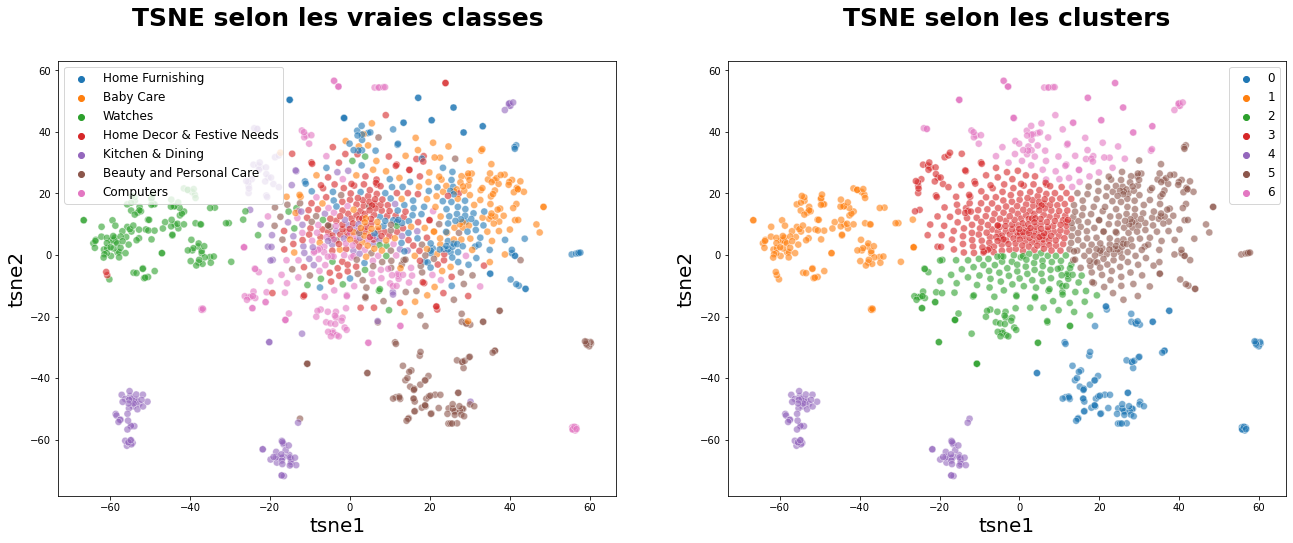

Score ARI :  0.3134691864854537


In [35]:
plt.rcParams["figure.figsize"] = (22,8)
fig, axes = plt.subplots(1,2)

sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_2, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,ax=axes[0])
axes[0].set_title('TSNE selon les vraies classes', fontsize = 25, pad = 35, fontweight = 'bold')

sns.scatterplot(
    x="tsne1", y="tsne2", hue="cluster", data=df_tsne_2, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,ax=axes[1])
axes[1].set_title('TSNE selon les clusters', fontsize = 25, pad = 35, fontweight = 'bold')

for i in range(2):
    axes[i].set_xlabel('tsne1', fontsize = 20)
    axes[i].set_ylabel('tsne2', fontsize = 20)
    axes[i].legend(prop={'size': 12}) 

plt.show()


# Calcul ARI
labels = data["label"]
print("Score ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

## Test 3 - Suppression des 5 dernières couches

In [36]:
# Création du modèle VGG
model_3 = VGG16()
model_3 = Model(inputs=model_3.inputs, outputs=model_3.layers[-6].output)  # Suppression de la dernière couche
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [37]:
def creation_feature_2(image,model):
    img = load_img(image, target_size=(224, 224))
    img = img_to_array(img)  # Convertir l'image en un array
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Reshape pour les besoins du modèle VGG
    img = preprocess_input(img)  # Preprocessing pour les besoins du modèle (soustraction de la moyenne RGB du modèle d'entrainement)
    features = model.predict(img,verbose=0)
    features = features.reshape(1,-1)
    return features

In [38]:
# Création des features
CNN_features = []

temps1=time.time()

for i in range(len(data)):
    features = creation_feature_2(path+data['image'][i],model_3)
    CNN_features.append(features)

duree = time.time() - temps1

CNN_features_par_image_3 = np.asarray(CNN_features)  # Utile pour la construction dse histogrammes 
CNN_features_total_3 = np.concatenate(CNN_features_par_image_3, axis=0)


print("Durée de création des features :" ,"%15.2f" % duree, "secondes")
print("Taille matrice :" , CNN_features_total_3.shape)

/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Durée de création des features :          136.80 secondes
Taille matrice : (1050, 100352)


### Réduction de dimension PCA

In [39]:
print("Dimensions dataset avant réduction PCA : ", CNN_features_total_3.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca_3= pca.fit_transform(CNN_features_total_3)
print("Dimensions dataset après réduction PCA : ", feat_pca_3.shape)

Dimensions dataset avant réduction PCA :  (1050, 100352)
Dimensions dataset après réduction PCA :  (1050, 952)


### Réduction de dimension T-SNE

In [40]:
# Recherche de la perplexity optimum
# Le juge de paix est le score ARI donc nécessité de réaliser un clustering avec 7 catégories

labels = data["label"]
ARI = []

perplexity_range = [1, 5, 10, 50, 100, 200, 300, 400, 500, 600, 1000]

for i in perplexity_range:
    X_tsne, df_tsne = application_TSNE(feat_pca_3, perplexity=i)
    cls = cluster.KMeans(n_clusters=7, random_state=42)
    cls.fit(X_tsne)
    ARI.append([metrics.adjusted_rand_score(labels, cls.labels_)])
    print("Perplexity :" , i, ", ARI :", metrics.adjusted_rand_score(labels, cls.labels_))

/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 1 , ARI : 0.018245858810676335


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 5 , ARI : 0.17894026428821933


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 10 , ARI : 0.2488976350911818


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 50 , ARI : 0.21352724211378335


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 100 , ARI : 0.2179452587098009


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 200 , ARI : 0.20955048094653297


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 300 , ARI : 0.19632224985575986


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 400 , ARI : 0.2057789997518563


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 500 , ARI : 0.19887728331160373


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 600 , ARI : 0.1794752093263594


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 1000 , ARI : 0.1278120341195633


In [41]:
# Application TSNE avec la perplexity optimisée
X_tsne_3, df_tsne_3 = application_TSNE(feat_pca_3, perplexity=perplexity_range[ARI.index(max(ARI))])

/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


###  Création de clusters à partir du T-SNE

In [42]:
# Application du KMeans
cls = cluster.KMeans(n_clusters=7, random_state=42)
cls.fit(X_tsne_3)

df_tsne_3["cluster"] = cls.labels_
print(df_tsne_3.shape)

(1050, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

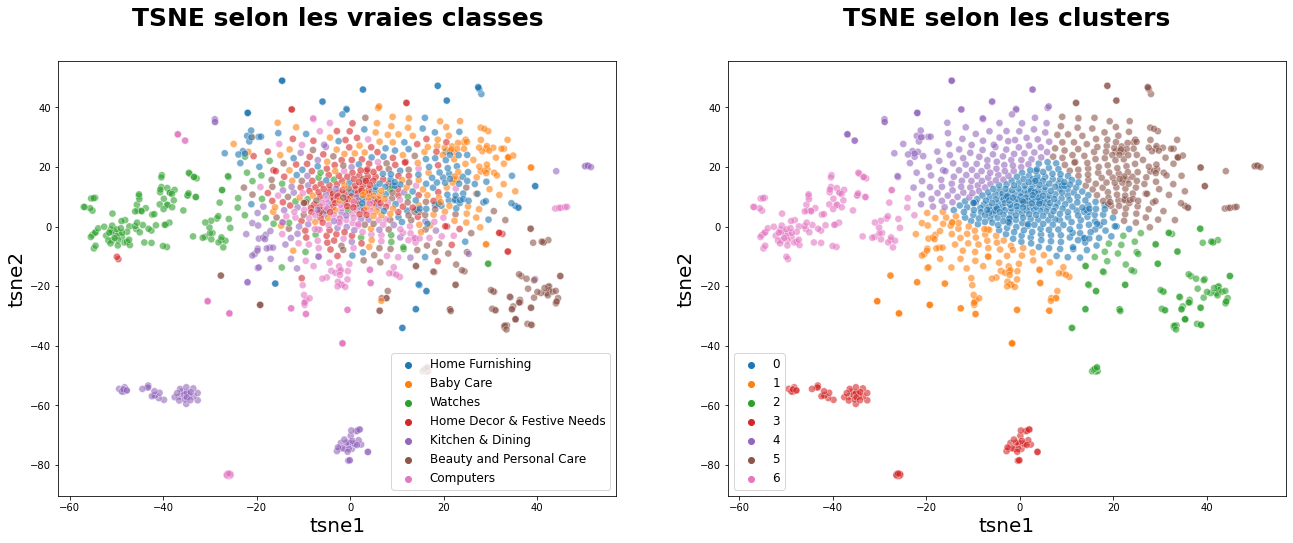

Score ARI :  0.2488976350911818


In [43]:
plt.rcParams["figure.figsize"] = (22,8)
fig, axes = plt.subplots(1,2)

sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_3, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,ax=axes[0])
axes[0].set_title('TSNE selon les vraies classes', fontsize = 25, pad = 35, fontweight = 'bold')

sns.scatterplot(
    x="tsne1", y="tsne2", hue="cluster", data=df_tsne_3, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,ax=axes[1])
axes[1].set_title('TSNE selon les clusters', fontsize = 25, pad = 35, fontweight = 'bold')

for i in range(2):
    axes[i].set_xlabel('tsne1', fontsize = 20)
    axes[i].set_ylabel('tsne2', fontsize = 20)
    axes[i].legend(prop={'size': 12}) 

plt.show()


# Calcul ARI
labels = data["label"]
print("Score ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

# Transfer learning : InceptionV3

In [44]:
model_Incep = InceptionV3()
model_Incep = Model(inputs=model.inputs, outputs=model.layers[-2].output)
model_Incep.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [45]:
# Création des features
Incep_features = []

temps1=time.time()

for i in range(len(data)):
    features = creation_feature(path+data['image'][i],model_Incep)
    Incep_features.append(features)

duree = time.time() - temps1

Incep_features_par_image = np.asarray(Incep_features)
Incep_features_total = np.concatenate(Incep_features_par_image, axis=0)


print("Durée de création des features :" ,"%15.2f" % duree, "secondes")
print("Taille matrice :" , Incep_features_total.shape)

/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Durée de création des features :          157.17 secondes
Taille matrice : (1050, 4096)


## Réductions de dimension

### Réduction de dimension PCA

In [46]:
print("Dimensions dataset avant réduction PCA : ", Incep_features_total.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(Incep_features_total)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 4096)
Dimensions dataset après réduction PCA :  (1050, 856)


### Réduction de dimension T-SNE

In [47]:
# Recherche de la perplexity optimum
# Le juge de paix est le score ARI donc nécessité de réaliser un clustering avec 7 catégories

labels = data["label"]
ARI = []

perplexity_range = [1, 5, 10, 50, 100, 200, 300, 400, 500, 600, 1000]

for i in perplexity_range:
    X_tsne, df_tsne = application_TSNE(feat_pca, perplexity=i)
    cls = cluster.KMeans(n_clusters=7, random_state=42)
    cls.fit(X_tsne)
    ARI.append([metrics.adjusted_rand_score(labels, cls.labels_)])
    print("Perplexity :" , i, ", ARI :", metrics.adjusted_rand_score(labels, cls.labels_))

/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 1 , ARI : 0.05343576582458055


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 5 , ARI : 0.36243247018769154


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 10 , ARI : 0.394821498537915


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 50 , ARI : 0.39109870496545157


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 100 , ARI : 0.44853552065441893


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 200 , ARI : 0.3918291378942672


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 300 , ARI : 0.31466345130203055


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 400 , ARI : 0.31523908713250265


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 500 , ARI : 0.2687849121030964


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 600 , ARI : 0.25597437420485886


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 1000 , ARI : 0.1572900041933939


In [48]:
# Application TSNE avec la perplexity optimisée
X_tsne, df_tsne = application_TSNE(feat_pca, perplexity=perplexity_range[ARI.index(max(ARI))])

/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


###  Création de clusters à partir du T-SNE

In [49]:
# Application du KMeans
cls = cluster.KMeans(n_clusters=7, random_state=42)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

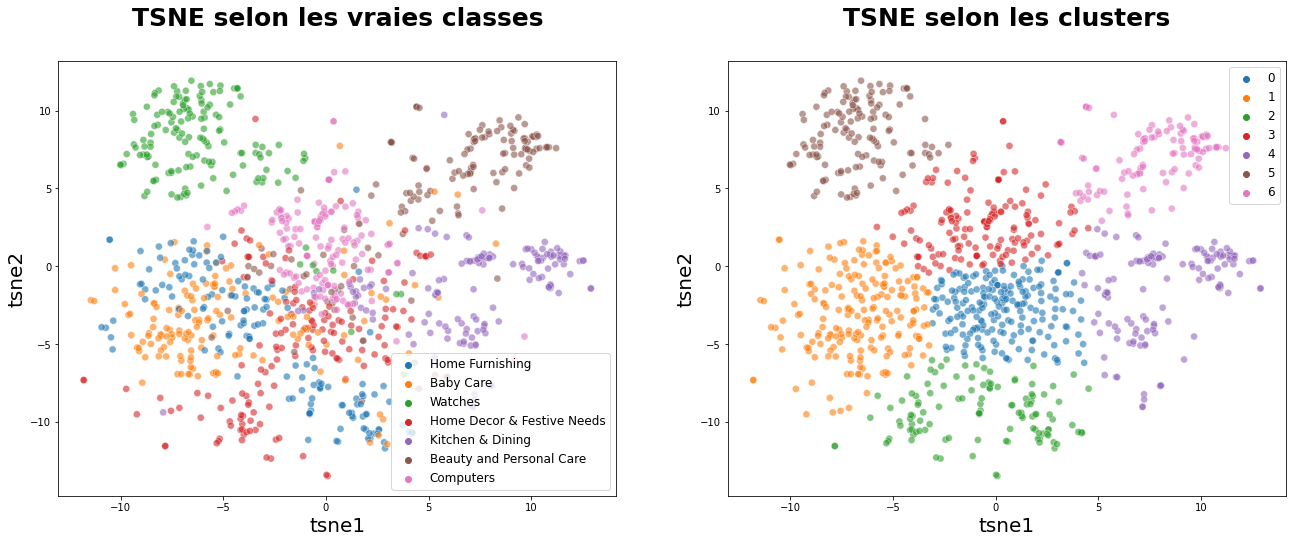

Score ARI :  0.44853552065441893


In [50]:
plt.rcParams["figure.figsize"] = (22,8)
fig, axes = plt.subplots(1,2)

sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,ax=axes[0])
axes[0].set_title('TSNE selon les vraies classes', fontsize = 25, pad = 35, fontweight = 'bold')
# plt.xlabel('tsne1' fontsize = 20)
# plt.ylabel('tsne2', fontsize = 20)
# plt.legend(prop={'size': 12}) 

sns.scatterplot(
    x="tsne1", y="tsne2", hue="cluster", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,ax=axes[1])
axes[1].set_title('TSNE selon les clusters', fontsize = 25, pad = 35, fontweight = 'bold')

for i in range(2):
    axes[i].set_xlabel('tsne1', fontsize = 20)
    axes[i].set_ylabel('tsne2', fontsize = 20)
    axes[i].legend(prop={'size': 12}) 

plt.show()


# Calcul ARI
labels = data["label"]
print("Score ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

## Test 4 - Suppression de la dernière couche "fully connected"
### et remplacement par des couches à entrainer pour la classification à 7 classes

In [51]:
# Définition des données d'entrainement
y = data.label
data_train = np.array([img_to_array(load_img(img,target_size=(224,224)))
                       for img in path+data['image']
                      ])
data_train.shape

/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(1050, 224, 224, 3)

In [52]:
# train-test-split
X_train, X_test, y_train, y_test = train_test_split(data_train, y, stratify=data['label'], test_size=0.5)

In [53]:
# Chargement du modèle VGG-16 sans les couches fully connected
model_4 = VGG16(include_top=False, input_shape=(224, 224, 3))
model_4.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [54]:
# Ajout d'une nouvelle couche fully-connected pour la classification à 7 classes
x = model_4.output
flat = Flatten()(x)  # Ajout d'une couche Flatten pour transformer la couche [7, 7, 512] en [25088]
predictions = Dense(7, activation='softmax')(flat) # Ajout de la classe de classification

# Définir le nouveau modèle
new_model = Model(inputs=model_4.input, outputs=[flat, predictions])

new_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

#############  
On pourrait rajouter une couche dense en plus de type 1024  
#############

In [55]:
# Blocage des entrainements des poids avant les dernières couches rajoutées
for layer in new_model.layers:
    layer.trainable = False

for layer in new_model.layers[-2:]:
    layer.trainable = True
        
# Compiler le modèle 
new_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Vérification des couches entrainables
for l in new_model.layers:
    print(l.name, l.trainable)

input_5 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False
flatten True
dense True


In [56]:
from tensorflow.keras.callbacks import EarlyStopping

# Entraînement des données
new_model.fit(X_train, y_train, verbose=2, validation_data=(X_test,y_test), epochs=2, callbacks=EarlyStopping(monitor='val_loss',patience=2))

Epoch 1/2
17/17 - 93s - loss: 48.6277 - flatten_loss: 23.7167 - dense_loss: 24.9110 - flatten_accuracy: 0.0000e+00 - dense_accuracy: 0.5790 - val_loss: 34.3906 - val_flatten_loss: 23.7819 - val_dense_loss: 10.6087 - val_flatten_accuracy: 0.0000e+00 - val_dense_accuracy: 0.7714 - 93s/epoch - 5s/step
Epoch 2/2
17/17 - 93s - loss: 25.5720 - flatten_loss: 23.7167 - dense_loss: 1.8553 - flatten_accuracy: 0.0000e+00 - dense_accuracy: 0.9295 - val_loss: 36.0161 - val_flatten_loss: 23.7819 - val_dense_loss: 12.2342 - val_flatten_accuracy: 0.0000e+00 - val_dense_accuracy: 0.7638 - 93s/epoch - 5s/step


In [57]:
score = new_model.evaluate(X_test,y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

17/17 [==============================] - 47s 3s/step - loss: 36.0161 - flatten_loss: 23.7819 - dense_loss: 12.2342 - flatten_accuracy: 0.0000e+00 - dense_accuracy: 0.7638
Test loss: 36.0161247253418
Test accuracy: 23.781904220581055


#############  
Une possibilité serait d'augmenter artificiellement le nombre d'images.  
https://www.datacorner.fr/vgg-transfer-learning/  
https://www.kaggle.com/code/shiftbc/fruit-and-vgg/notebook  
#############

#############  
L'objectif ici est de faire prédire le modèle pour calculer l'accuracy. Attention, si on rentraine le modèle sans le redefinir, il fera une époque supplémentaire.  
Pas compris pourquoi l'accuracy de la couche issue du fit est différente de l'accuracy testée plus bas  
#############

In [59]:
# Réalise les prédictions sur le jeu de test
predictions_test = new_model.predict(X_test)

17/17 [==============================] - 47s 3s/step


In [60]:
# Récupération des prédictions (probabilité d'être dans chaque cluster)
predictions_test = pd.DataFrame(predictions_test[1])
# Création d'une nouvelle colonne pour la proba max = cluster sélectionné
predictions_test['Max'] = predictions_test.idxmax(axis=1)

In [61]:
# Calcul de l'accuracy sur le jeu de test
print("Accuracy : ", metrics.accuracy_score(y_test, predictions_test['Max']))
print("ARI : ", metrics.adjusted_rand_score(y_test, predictions_test['Max']))

Accuracy :  0.7638095238095238
ARI :  0.5375485612511206


<AxesSubplot:>

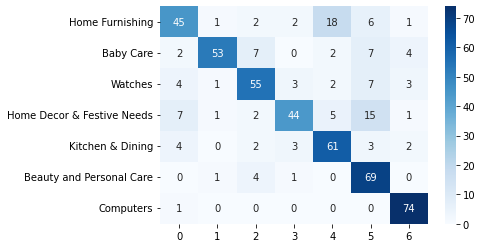

In [62]:
conf_mat = metrics.confusion_matrix(y_test, predictions_test['Max'])
df_cm = pd.DataFrame(conf_mat, index = [label for label in categories],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")


In [63]:
print(metrics.classification_report(y_test, predictions_test['Max']))

              precision    recall  f1-score   support

           0       0.71      0.60      0.65        75
           1       0.93      0.71      0.80        75
           2       0.76      0.73      0.75        75
           3       0.83      0.59      0.69        75
           4       0.69      0.81      0.75        75
           5       0.64      0.92      0.76        75
           6       0.87      0.99      0.93        75

    accuracy                           0.76       525
   macro avg       0.78      0.76      0.76       525
weighted avg       0.78      0.76      0.76       525



In [64]:
# Réalise les prédictions sur le jeu de train
predictions_train = new_model.predict(X_train)

17/17 [==============================] - 46s 3s/step


In [65]:
# Récupération des prédictions (probabilité d'être dans chaque cluster)
predictions_train = pd.DataFrame(predictions_train[1])
# Création d'une nouvelle colonne pour la proba max = cluster sélectionné
predictions_train['Max'] = predictions_train.idxmax(axis=1)

In [66]:
# Calcul de l'accuracy sur le jeu de test
print("Accuracy : ", metrics.accuracy_score(predictions_train['Max'], y_train))
print("ARI : ", metrics.adjusted_rand_score(predictions_train['Max'], y_train))

Accuracy :  0.9676190476190476
ARI :  0.9265509344779063


In [67]:
# Aucun interet ici mais permet de récupérer uniquement les résultats de la dernière couche dense (sans la flatten)
def creation_feature_3(image,model):
    img = load_img(image, target_size=(224, 224))
    img = img_to_array(img)  # Convertir l'image en un array
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Reshape pour les besoins du modèle VGG
    img = preprocess_input(img)  # Preprocessing pour les besoins du modèle (soustraction de la moyenne RGB du modèle d'entrainement)
    results = model.predict(img,verbose=0)
    results = results[1]
    return results

In [68]:
# Création des features
CNN_features = []

temps1=time.time()

for i in range(len(data)):
    features = creation_feature_3(path+data['image'][i],new_model)
    CNN_features.append(features)

duree = time.time() - temps1

CNN_features_par_image_4 = np.asarray(CNN_features)  # Utile pour la construction dse histogrammes 
CNN_features_total_4 = np.concatenate(CNN_features_par_image_4, axis=0)


print("Durée de création des features :" ,"%15.2f" % duree, "secondes")
print("Taille matrice :" , CNN_features_total_4.shape)

/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Durée de création des features :          137.15 secondes
Taille matrice : (1050, 7)


### Réduction de dimension T-SNE

In [69]:
# Recherche de la perplexity optimum
# Le juge de paix est le score ARI donc nécessité de réaliser un clustering avec 7 catégories

labels = data["label"]
ARI = []

perplexity_range = [1, 5, 10, 50, 100, 200, 300, 400, 500, 600, 1000]

for i in perplexity_range:
    X_tsne, df_tsne = application_TSNE(CNN_features_total_4, perplexity=i)
    cls = cluster.KMeans(n_clusters=7, random_state=42)
    cls.fit(X_tsne)
    ARI.append([metrics.adjusted_rand_score(labels, cls.labels_)])
    print("Perplexity :" , i, ", ARI :", metrics.adjusted_rand_score(labels, cls.labels_))

/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 1 , ARI : 0.49529280104078194


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 5 , ARI : 0.6919653100644175


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 10 , ARI : 0.6923193034310287


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 50 , ARI : 0.6942053728910033


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 100 , ARI : 0.6943364257530511


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 200 , ARI : 0.6943364257530511


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 300 , ARI : 0.6943364257530511


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 400 , ARI : 0.6943364257530511


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 500 , ARI : 0.6943364257530511


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 600 , ARI : 0.6943364257530511


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 1000 , ARI : 0.6943364257530511


In [70]:
# Application TSNE avec la perplexity optimisée
X_tsne_4, df_tsne_4 = application_TSNE(CNN_features_total_4, perplexity=perplexity_range[ARI.index(max(ARI))])

/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


###  Création de clusters à partir du T-SNE

In [71]:
# Application du KMeans
cls = cluster.KMeans(n_clusters=7, random_state=42)
cls.fit(X_tsne_4)

df_tsne_4["cluster"] = cls.labels_
print(df_tsne_4.shape)

(1050, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

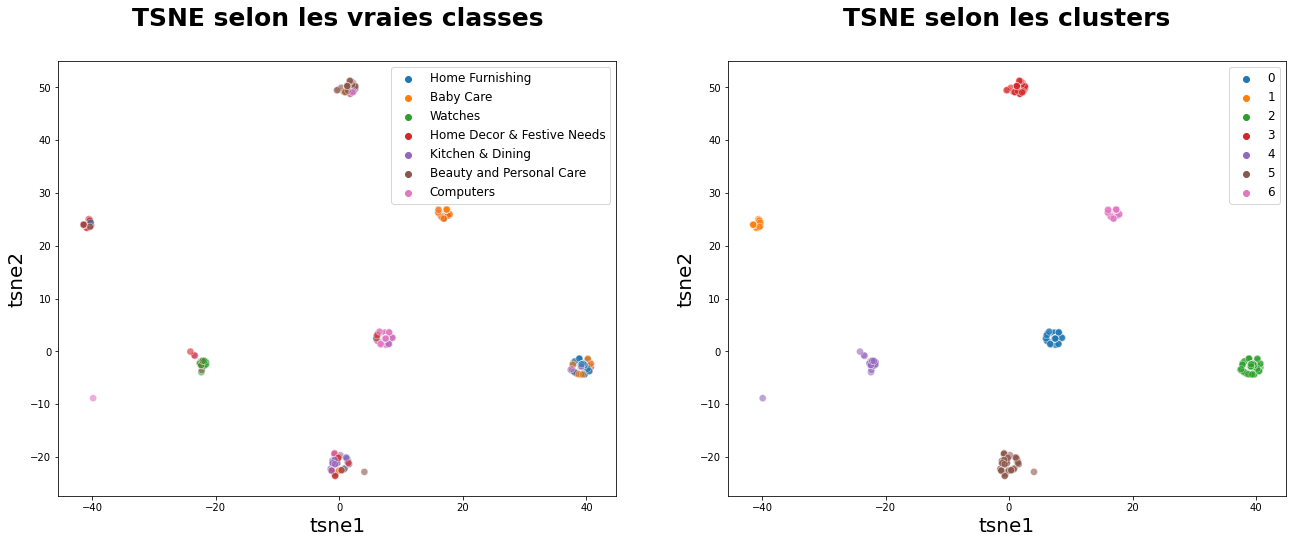

Score ARI :  0.6943364257530511


In [72]:
plt.rcParams["figure.figsize"] = (22,8)
fig, axes = plt.subplots(1,2)

sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_4, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,ax=axes[0])
axes[0].set_title('TSNE selon les vraies classes', fontsize = 25, pad = 35, fontweight = 'bold')

sns.scatterplot(
    x="tsne1", y="tsne2", hue="cluster", data=df_tsne_4, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,ax=axes[1])
axes[1].set_title('TSNE selon les clusters', fontsize = 25, pad = 35, fontweight = 'bold')

for i in range(2):
    axes[i].set_xlabel('tsne1', fontsize = 20)
    axes[i].set_ylabel('tsne2', fontsize = 20)
    axes[i].legend(prop={'size': 12}) 

plt.show()


# Calcul ARI
labels = data["label"]
print("Score ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

# Mix des données texte et images

In [73]:
# Importation des données
data_text = pd.read_csv('Data_textes_tf_idf.csv')
data_images = pd.DataFrame(CNN_features_total)

df_data_fusionnees = pd.concat([data_text,data_images],axis=1)
df_data_fusionnees.shape

(1050, 4641)

In [74]:
# Nécessité de normaliser les données par colonnes, pour que le texte et les images aient les mêmes poids
scaler = preprocessing.MinMaxScaler()
scaler.fit(df_data_fusionnees.values)
data_fusionnees = scaler.fit_transform(df_data_fusionnees.values)
df_data_fusionnees_scaled = pd.DataFrame(data_fusionnees, columns=df_data_fusionnees.columns)
df_data_fusionnees_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
count,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,...,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000
mean,0.023210,0.006321,0.005381,0.011360,0.035266,0.018289,0.015083,0.012430,0.018485,0.020193,...,0.051226,0.030222,0.013320,0.041339,0.067768,0.103331,0.070134,0.074172,0.049923,0.118965
std,0.122152,0.060288,0.051558,0.095165,0.128832,0.103308,0.095502,0.103996,0.083723,0.135540,...,0.133841,0.111625,0.073761,0.116381,0.153062,0.153398,0.150610,0.149383,0.130765,0.185691
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.003412,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.032126,0.168048,0.068733,0.079372,0.000000,0.183471
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Réductions de dimension

### Réduction de dimension PCA

In [75]:
print("Dimensions dataset avant réduction PCA : ", data_fusionnees.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(data_fusionnees)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 4641)
Dimensions dataset après réduction PCA :  (1050, 847)


### Réduction de dimension T-SNE

In [76]:
# Recherche de la perplexity optimum
# Le juge de paix est le score ARI donc nécessité de réaliser un clustering avec 7 catégories

labels = data["label"]
ARI = []

perplexity_range = [1, 5, 10, 50, 100, 200, 300, 400, 500, 600, 1000]

for i in perplexity_range:
    X_tsne, df_tsne = application_TSNE(feat_pca, perplexity=i)
    cls = cluster.KMeans(n_clusters=7, random_state=42)
    cls.fit(X_tsne)
    ARI.append([metrics.adjusted_rand_score(labels, cls.labels_)])
    print("Perplexity :" , i, ", ARI :", metrics.adjusted_rand_score(labels, cls.labels_))

/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 1 , ARI : 0.02979314093459402


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 5 , ARI : 0.4739314421535887


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 10 , ARI : 0.5445987982797642


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 50 , ARI : 0.5392132944022878


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 100 , ARI : 0.5336215452733586


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 200 , ARI : 0.45792670931143153


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 300 , ARI : 0.40661837754382446


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 400 , ARI : 0.5047795854679237


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 500 , ARI : 0.40841824575404684


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 600 , ARI : 0.3606916157045419


/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Perplexity : 1000 , ARI : 0.318104765240959


In [77]:
# Application TSNE avec la perplexity optimisée
X_tsne, df_tsne = application_TSNE(feat_pca, perplexity=perplexity_range[ARI.index(max(ARI))])

/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


###  Création de clusters à partir du T-SNE

In [78]:
# Application du KMeans
cls = cluster.KMeans(n_clusters=7, random_state=42)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

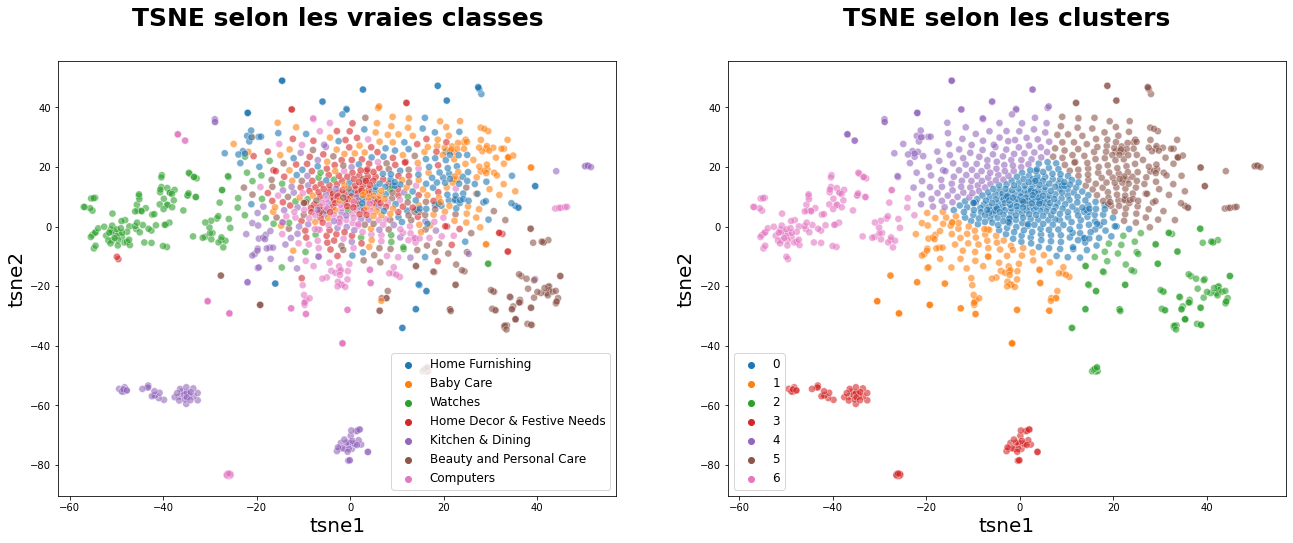

Score ARI :  0.5445987982797642


In [79]:
plt.rcParams["figure.figsize"] = (22,8)
fig, axes = plt.subplots(1,2)

sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_3, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,ax=axes[0])
axes[0].set_title('TSNE selon les vraies classes', fontsize = 25, pad = 35, fontweight = 'bold')

sns.scatterplot(
    x="tsne1", y="tsne2", hue="cluster", data=df_tsne_3, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,ax=axes[1])
axes[1].set_title('TSNE selon les clusters', fontsize = 25, pad = 35, fontweight = 'bold')

for i in range(2):
    axes[i].set_xlabel('tsne1', fontsize = 20)
    axes[i].set_ylabel('tsne2', fontsize = 20)
    axes[i].legend(prop={'size': 12}) 

plt.show()


# Calcul ARI
labels = data["label"]
print("Score ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))